In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
n_KC = 15000
n_PN = 90

pn_traces = np.load("AL_output.npy")[1000:2000,:n_PN]

In [14]:
pn_spikes = np.int32(np.logical_and(pn_traces[1:,:]>0,pn_traces[:-1,:]<0))
duration = pn_spikes.shape[0]

In [39]:
cmatrix = np.random.choice([1,0],size=(n_KC,n_PN),p=[0.3,0.7])

In [40]:
u = 0.0012 + np.random.uniform(-0.00068,0.00068,n_KC)
Be = 0.03
sigma = 0.06 + np.random.exponential(0.0072,n_KC)
sigmae = 1
alpha= 3.65

x_KC = (sigma-1)*np.ones((int(duration)+2,n_KC))
y_KC = x_KC - alpha/(1-x_KC)

n_syn = np.sum(cmatrix)
g_PNKC = np.zeros((int(duration)+2,n_syn))
I_PNKC = np.zeros((int(duration)+2,n_KC))
gamma = 0.4
G_PNKC = 0.000066
S_den = 165e-6

E_ach = 0

def f_alpha(xn,xnm1,u):
    return np.where(xn <=0, alpha/(1-xn)+ u, np.where(np.logical_and(xnm1<=0,xn<alpha+u),alpha+u,-np.ones(n_KC)) )


u_ggn = 0.05
sigma_ggn = -0.5
alpha_ggn = 0.8

def ggn_f(xn):
    return np.where(xn<-3,-2,np.where(xn>3,2,xn-xn**3/27))

x_GGN = (sigma_ggn-1)*np.ones(int(duration)+2)
y_GGN = alpha_ggn*(x_GGN - x_GGN**3/27) - x_GGN

g_KCGGN = np.zeros((int(duration)+2,n_KC))
I_KCGGN = np.zeros(int(duration)+2)
G_KCGGN = 0.5

g_GGNKC = np.zeros((int(duration)+2,n_KC))
I_GGNKC = np.zeros((int(duration)+2,n_KC))
G_GGNKC = 0.00004
E_gaba = -0.7
for i in range(2,x_KC.shape[0]):
    print("{}/{}".format(i,x_KC.shape[0]),end='\r')
    
    g_PNKC[i,:] = gamma*g_PNKC[i-1,:] + G_PNKC/S_den * (cmatrix*pn_spikes[i-2,:])[cmatrix>0]
    
    I_PNKC_t = np.float64(np.copy(cmatrix))
    np.putmask(I_PNKC_t,cmatrix>0,g_PNKC[i-1,:])
    I_PNKC[i,:] = (-I_PNKC_t.T*(((x_KC[i-1,:]-E_ach)<0)*(x_KC[i-1,:]-E_ach))).sum(axis=0)
    
    x_KC[i,:] = f_alpha(x_KC[i-1,:],x_KC[i-2,:],y_KC[i-1,:]+np.clip(Be*(I_PNKC[i-1,:]+I_GGNKC[i-1,:]),-1,1))
    y_KC[i,:] = y_KC[i-1,:] - u*(1+x_KC[i-1,:]) + u*(sigma+sigmae*I_PNKC[i-1,:])
    
    spiking = np.logical_or(x_KC[i-1]>=alpha+y_KC[i-1,:]+Be*I_PNKC[i,:],x_KC[i-2,:]>0)
    
    g_KCGGN[i,:] = gamma*g_KCGGN[i-1,:] + G_KCGGN * spiking
    
    I_KCGGN[i] = -np.sum(g_KCGGN[i,:]*((x_GGN[i]-E_ach)*(x_GGN[i]-E_ach<0)))
    
    x_GGN[i] = alpha_ggn*ggn_f(x_GGN[i-1]) - y_GGN[i-1]
    y_GGN[i] = y_GGN[i-1] + u_ggn*(1+x_GGN[i-1]) - u_ggn*(sigma_ggn+sigmae*I_KCGGN[i])
    
    g_GGNKC[i,:] = gamma*g_GGNKC[i-1,:] + (x_GGN[i-1]>1.4)*(1/(1+np.exp(1-x_GGN[i-1]/1.5)*G_GGNKC/S_den))
    I_GGNKC[i,:] = -g_GGNKC[i-1,:]*(x_KC[i-1,:]-E_gaba)
    

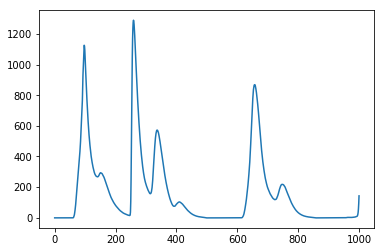

In [46]:
plt.plot(x_GGN)

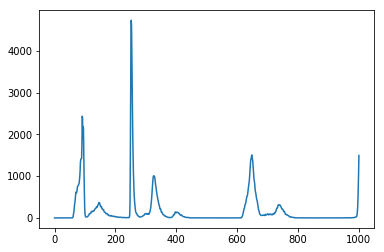

In [47]:
plt.plot(I_KCGGN[:])

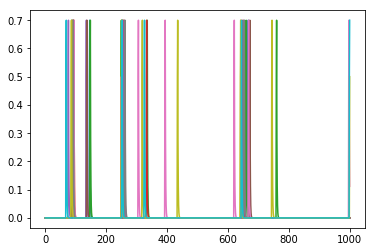

In [48]:
plt.plot(g_KCGGN[:,:10])

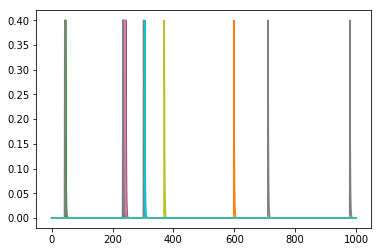

In [49]:
plt.plot(g_PNKC[:,:10])

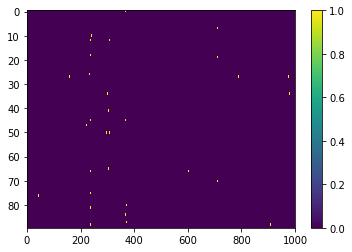

In [50]:
plt.imshow(pn_spikes.T,aspect='auto')
plt.colorbar()

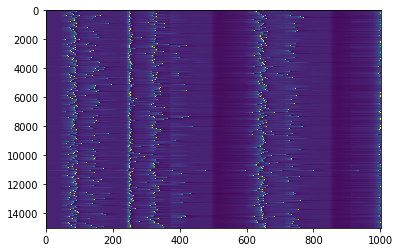

In [51]:
plt.imshow(x_KC.T,aspect='auto')

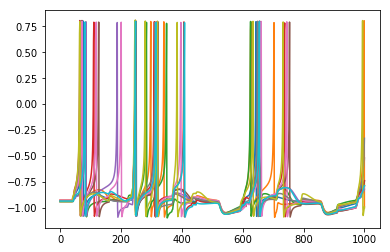

In [38]:
plt.plot(x_KC[:,:10])

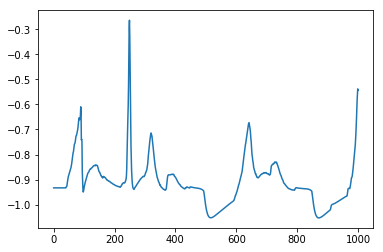

In [45]:
plt.plot(x_KC.mean(axis=1))